In [ ]:
# %pip install tensorboard

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# %pip install torchmetrics

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
# %% Imports and Setup
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from torchmetrics import F1Score
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from PIL import Image

# Set device
device = torch.device('cuda')
scaler = torch.amp.GradScaler('cuda') # For mixed precision training


In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Data Transformation and Dataset Splitting with 160x160 Image Size
train_transform = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
from torchvision.datasets import ImageFolder
root_dir = "new_house_plant_species_split(balanced)"

train_data = ImageFolder(root = r'new_house_plant_species_split\train', transform=train_transform)

val_data = ImageFolder(root = r'new_house_plant_species_split\val', transform=val_test_transform)

test_data = ImageFolder(root = r'new_house_plant_species_split\test', transform=val_test_transform)


#train_data = custom_dataset(mode='train',root=root_dir, transforms=train_transform)
#val_data = custom_dataset(mode='val',root=root_dir,transforms=val_test_transform)
# test_data = custom_dataset(mode='test',root=root_dir,transforms=val_test_transform)

In [8]:
# Create data loaders
train_loader =DataLoader(train_data, batch_size=32, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)
test_loader =DataLoader(test_data, batch_size=16, shuffle=False)

In [9]:
def count_images_in_classes(root_dir):
    
    class_counts = {}

    
    for class_name in sorted(os.listdir(root_dir)):
        class_path = os.path.join(root_dir, class_name)
        if os.path.isdir(class_path):
            num_images = len([file for file in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, file))])
            class_counts[class_name] = num_images

    return class_counts


root_dir1 = "new_house_plant_species_split/train"  # Replace with your dataset folder path
counts = count_images_in_classes(root_dir1)

# Print class counts
i=1
for class_name, num_images in counts.items():
    print(f"Class '{i}': {num_images} images")
    i+=1


Class '1': 233 images
Class '2': 175 images
Class '3': 318 images
Class '4': 132 images
Class '5': 118 images
Class '6': 165 images
Class '7': 126 images
Class '8': 203 images
Class '9': 213 images
Class '10': 231 images
Class '11': 186 images
Class '12': 265 images
Class '13': 358 images
Class '14': 216 images
Class '15': 146 images
Class '16': 242 images
Class '17': 292 images
Class '18': 182 images
Class '19': 378 images
Class '20': 232 images
Class '21': 168 images
Class '22': 222 images
Class '23': 186 images
Class '24': 247 images
Class '25': 91 images
Class '26': 335 images
Class '27': 287 images
Class '28': 251 images
Class '29': 382 images
Class '30': 163 images
Class '31': 229 images
Class '32': 268 images
Class '33': 213 images
Class '34': 238 images
Class '35': 137 images
Class '36': 170 images
Class '37': 280 images
Class '38': 220 images
Class '39': 203 images
Class '40': 141 images
Class '41': 226 images
Class '42': 277 images
Class '43': 238 images
Class '44': 238 image

In [10]:
train_loader

In [11]:
def show_sample_images(loader, class_names, grid_size=6):
    # Get a batch of data
    data_iter = iter(loader)
    images, labels = next(data_iter)

    # Adjust grid size for visualization
    grid_count = min(grid_size * grid_size, len(images))  # Ensure we don't exceed batch size
    images = images[:grid_count]
    labels = labels[:grid_count]

    # Unnormalize images
    images = images / 2 + 0.5  # Unnormalize
    images = torch.clamp(images, 0, 1)

    # Create a grid of subplots
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    axs = axs.flatten()

    for idx, (img, label) in enumerate(zip(images, labels)):
        if idx >= grid_count:  # Stop if we exceed available images
            break

        # Convert tensor to numpy and reshape
        img = img.cpu().numpy()
        img = np.transpose(img, (1, 2, 0))  # Convert (C, H, W) -> (H, W, C)

        # Decode label (handle both one-hot and index)
        if len(label.shape) > 0 and label.shape[0] == len(class_names):  # One-hot encoding
            class_index = torch.argmax(label).item()
        else:  # Index encoding
            class_index = label.item()

        class_name = class_names[class_index]

        # Plot the image
        axs[idx].imshow(img)
        axs[idx].set_title(class_name, fontsize=8)
        axs[idx].axis("off")

    # Turn off axes for unused grid spaces
    for ax in axs[grid_count:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


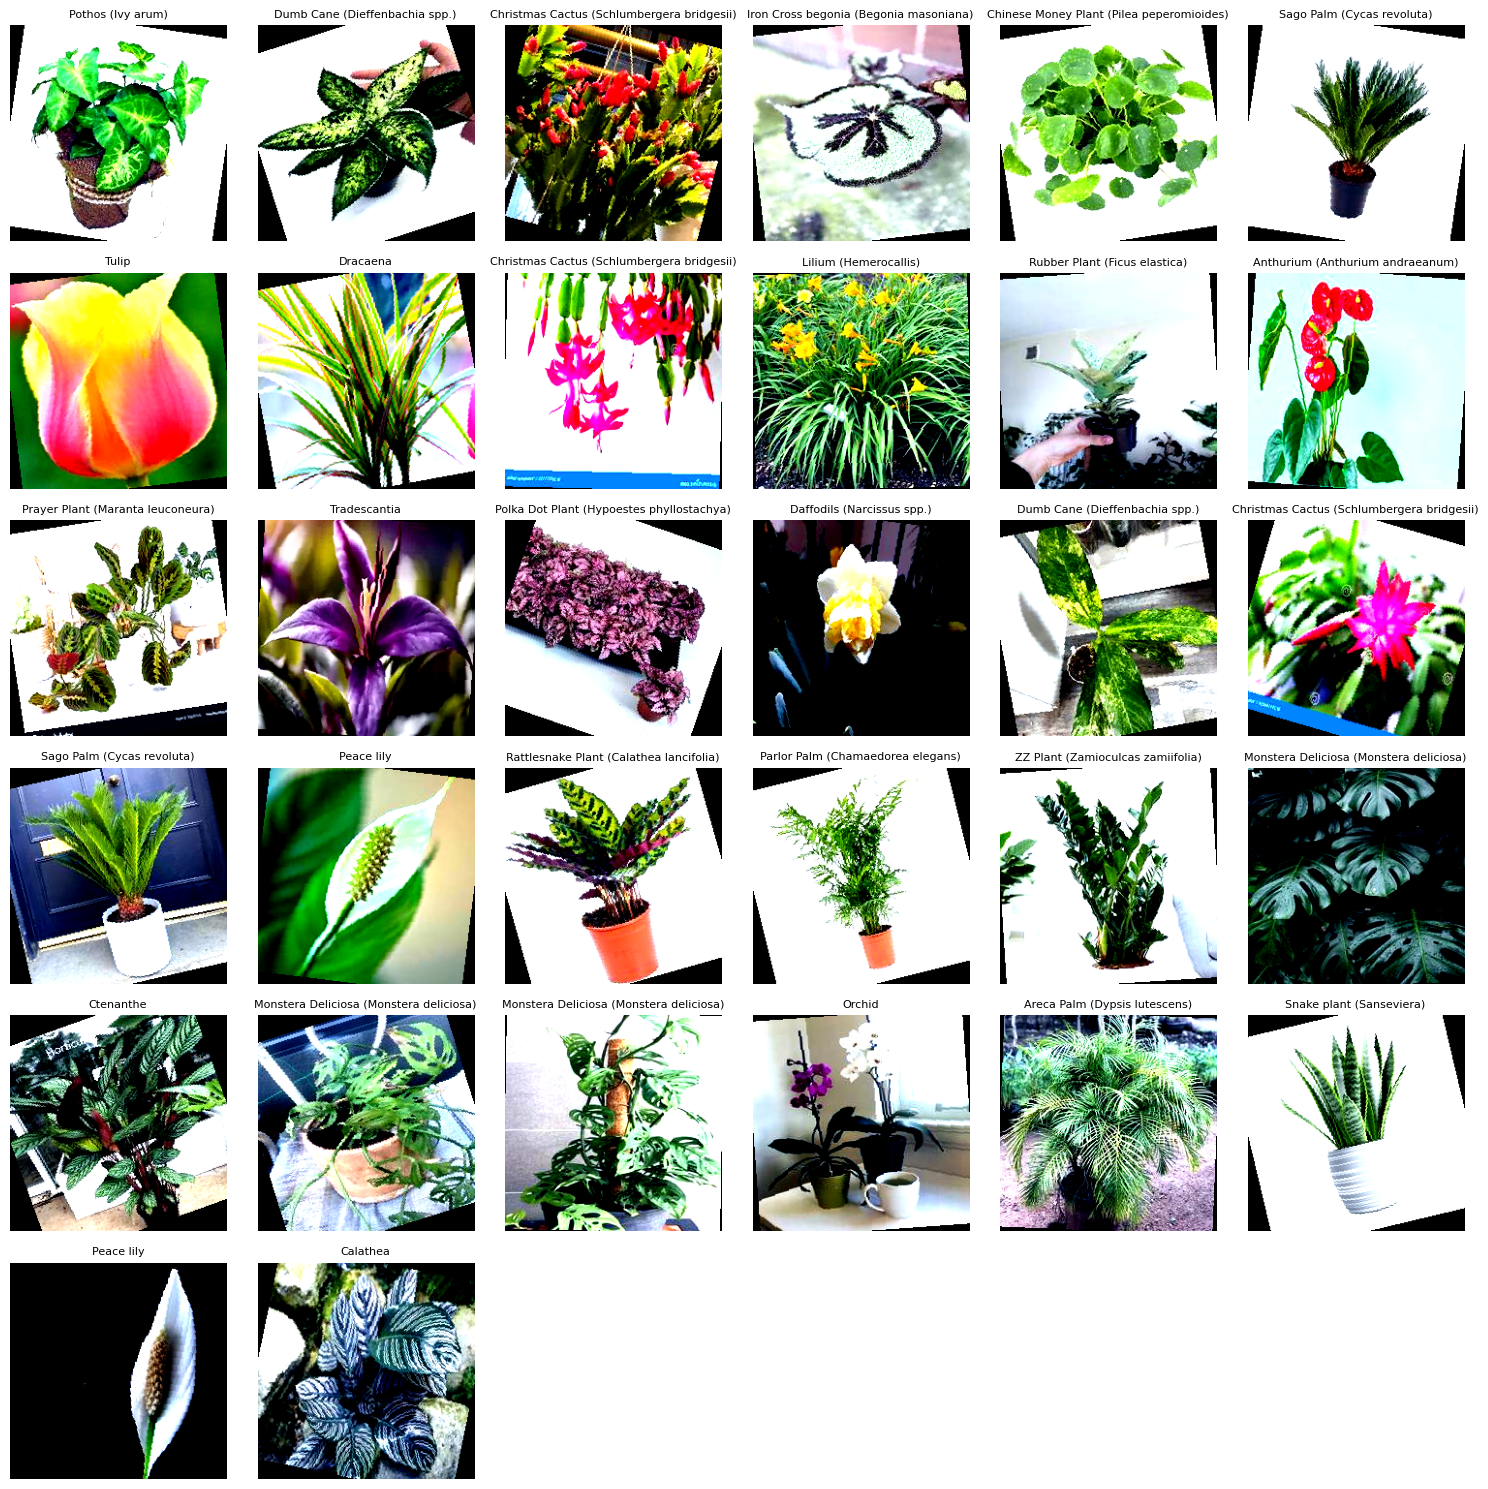

In [12]:
# Class names from your dataset
class_names = list(train_data.class_to_idx.keys())

# Call the function to display a grid
show_sample_images(train_loader, class_names)



#### Resnet models


In [13]:
class CustomResNet18Model_without_transfer(nn.Module):
    def __init__(self, num_classes=47):
        super(CustomResNet18Model_without_transfer, self).__init__()
        resnet18 = models.resnet18(pretrained=False)
        
        # Add batch normalization within the feature extractor
        feature_extractor_layers = []
        for layer in list(resnet18.children())[:-1]:  # Exclude the last fully connected layer
            feature_extractor_layers.append(layer)
            if isinstance(layer, nn.Conv2d):  # Add BatchNorm after Conv2d layers
                feature_extractor_layers.append(nn.BatchNorm2d(layer.out_channels))
        
        self.feature_extractor = nn.Sequential(*feature_extractor_layers)
        self.classifier = nn.Linear(resnet18.fc.in_features, num_classes)

    def forward(self, x):
        features = self.feature_extractor(x).squeeze()
        out = self.classifier(features)
        return out



class CustomResNet18Model_with_transfer(nn.Module):
    def __init__(self, num_classes=47):
        super().__init__()
        self.resnet18 = models.resnet18(pretrained=True)
        #self.feature_extractor = nn.Sequential(*(list(self.resnet18.children())[:-1]))
        
        # for param in self.resnet18.parameters():
        #     param.requires_grad=False
        
        self.resnet18.fc = nn.Linear(self.resnet18.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet18(x)


#### VGG Models


In [14]:
from torchvision import models
    
class VGG16NoTransferModel(nn.Module):
    def __init__(self, num_classes=47):
        super(VGG16NoTransferModel, self).__init__()
        vgg16 = models.vgg16(pretrained=False)
        
        # Add batch normalization within the feature extractor
        feature_extractor_layers = []
        for layer in list(vgg16.features.children()):
            feature_extractor_layers.append(layer)
            if isinstance(layer, nn.Conv2d):  # Add BatchNorm after Conv2d layers
                feature_extractor_layers.append(nn.BatchNorm2d(layer.out_channels))
        
        self.feature_extractor = nn.Sequential(*feature_extractor_layers)
        self.classifier = nn.Linear(25088, num_classes)  

    def forward(self, x):
        features = self.feature_extractor(x)
        features = features.view(features.size(0), -1)  # Flatten the features
        out = self.classifier(features)
        return out

    
    
class VGG16TransferModel(nn.Module):
    def __init__(self, num_classes=47):
        super(VGG16TransferModel, self).__init__()
        # Load the pre-trained VGG16 model
        self.vgg16 = models.vgg16(pretrained=True)

        # Modify the classifier part of VGG16
        self.vgg16.classifier[6] = nn.Linear(self.vgg16.classifier[6].in_features, num_classes)

    def forward(self, x):
        return self.vgg16(x)


#### Train function


In [15]:
from torch.nn.functional import softmax

In [22]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5, model_type='model', checkpoint_path=None):
    writer = SummaryWriter(log_dir=f'runs/{model_type}')
    scaler = torch.amp.GradScaler('cuda')
    f1_metric = F1Score(task='multiclass', num_classes=47).to(device)  # F1 score for validation
    start_epoch = 0

    # Check if a checkpoint exists and load it
    if checkpoint_path and os.path.exists(checkpoint_path):
        print(f"Loading checkpoint from {checkpoint_path}...")
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        start_epoch = checkpoint['epoch']
        print(f"Resuming from epoch {start_epoch}...")

    for epoch in range(start_epoch, num_epochs):
        print(f"-------- Starting Epoch {epoch+1}/{num_epochs} --------")
        model.train()
        running_loss = 0.0

        tq = tqdm(total=len(train_loader), desc="Training", position=0, leave=True)
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.amp.autocast('cuda'):
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * images.size(0)
            tq.update(1)
            tq.set_postfix(loss=f'{loss.item():.4f}')
            

        tq.close()
        epoch_loss = running_loss / len(train_loader.dataset)
        writer.add_scalar('Train Loss', epoch_loss, epoch)
        
        # Validation Loop
        model.eval()
        val_loss, val_corrects = 0.0, 0
        all_preds, all_labels = [], []
        tq = tqdm(total=len(val_loader), desc="Validation", position=0, leave=True)

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                with torch.amp.autocast('cuda'):
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                # Collect raw outputs and labels
                all_preds.append(outputs)  # Collect raw logits/probabilities
                all_labels.extend(torch.argmax(labels, dim=1).tolist() if labels.dim() > 1 else labels.tolist())

                val_loss += loss.item() * images.size(0)
                tq.update(1)
                tq.set_postfix(loss=f'{loss.item():.4f}')
                

        tq.close()
        val_loss /= len(val_loader.dataset)

        # Convert predictions and labels to tensors
        all_preds = torch.cat(all_preds, dim=0)
        all_labels = torch.tensor(all_labels).to(device)

        all_preds = softmax(all_preds, dim=1)  # Convert logits to probabilities
        
        val_f1 = f1_metric(all_preds, all_labels).item()
        
        writer.add_scalar('Validation Loss', val_loss, epoch,)
        writer.add_scalar('Validation F1 Score', val_f1, epoch)

        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f},\n'
              f' Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}')

        # Save the Model
        checkpoint = {
            'epoch': epoch + 1,  # Save the next epoch to resume from
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }
        torch.save(checkpoint, checkpoint_path)
        print(f"Checkpoint saved at {checkpoint_path}")


#### Evaluation function


In [28]:
import os
import torch
from torchmetrics.classification import F1Score

def load_model_from_checkpoint(model, checkpoint_path, device):
    if os.path.exists(checkpoint_path):
        print(f"Loading checkpoint from {checkpoint_path}...")
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['state_dict'])
        print(f"Checkpoint loaded from {checkpoint_path}")
    else:
        print(f"Checkpoint {checkpoint_path} not found!")

    return model

def evaluate_model_from_checkpoint(checkpoint_path, model_class, test_loader, device):
    # Initialize the model class
    model = model_class(num_classes=len(test_loader.dataset.class_to_idx)).to(device)

    # Load the model weights from the checkpoint
    model = load_model_from_checkpoint(model, checkpoint_path, device)

    # Set the model to evaluation mode
    model.eval()

    # Initialize counters for class-wise accuracy and F1 score
    num_classes = len(test_loader.dataset.class_to_idx)  # Number of classes
    correct_class = torch.zeros(num_classes, device=device)
    total_class = torch.zeros(num_classes, device=device)

    f1 = F1Score(num_classes=num_classes, average='macro', task='multiclass').to(device)

    # Evaluate the model
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Get model predictions
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            # Update F1 score
            f1.update(predicted, labels)

            # Update class-wise accuracy
            for i, label in enumerate(labels):
                correct_class[label] += (predicted[i] == label).item()
                total_class[label] += 1

    # Calculate overall accuracy
    total_correct = correct_class.sum().item()
    total_samples = total_class.sum().item()
    accuracy = 100 * total_correct / total_samples

    # Calculate F1 score
    f1_score = f1.compute().item()

    return accuracy, f1_score

def evaluate_all_models(checkpoints, model_classes, test_loader, device):
    
    for checkpoint, model_class in zip(checkpoints, model_classes):
        accuracy, f1_score = evaluate_model_from_checkpoint(checkpoint, model_class, test_loader, device)
        model_name = checkpoint.split('/')[-1]  # Extract model name from the checkpoint path
        print(f"\nResults for {model_name}:")
        print(f"Accuracy: {accuracy:.2f}%")
        print(f"F1 Score: {f1_score:.2f}\n")

# Example usage:
checkpoints = [
    'checkpoints/resnet18_transfer_SGD_checkpoint.pth',
    'checkpoints/resnet18_transfer_Adam_checkpoint.pth',
    'checkpoints/resnet18_without_transfer_test_N_SGD_checkpoint.pth',
    'checkpoints/resnet18_without_transfer_Adam_checkpoint.pth',
    'checkpoints/vgg16_transfer_SGD_checkpoint.pth',
    'checkpoints/vgg16_transfer_Adam_checkpoint.pth',
    'checkpoints/vgg16_no_transfer_SGD_checkpoint.pth',
    'checkpoints/vgg16_no_transfer_Adam_checkpoint.pth'
]

# Model classes corresponding to each checkpoint
model_classes = [
    CustomResNet18Model_with_transfer,    # ResNet18 Pretrained with SGD
    CustomResNet18Model_with_transfer,    # ResNet18 Pretrained with Adam
    CustomResNet18Model_without_transfer, # ResNet18 Not Pretrained with SGD
    CustomResNet18Model_without_transfer, # ResNet18 Not Pretrained with Adam
    VGG16TransferModel,   # VGG16 Not Pretrained with SGD
    VGG16TransferModel,   # VGG16 Not Pretrained with Adam
    VGG16NoTransferModel,      # VGG16 Pretrained with SGD
    VGG16NoTransferModel     # VGG16 Pretrained with Adam
]

# Assuming 'test_loader' is your DataLoader for the test set, and the device is 'cuda'
# evaluate_all_models(checkpoints, model_classes, test_loader, device='cuda')

In [18]:
# Training and Evaluation for Each Model
criterion = nn.CrossEntropyLoss()

#### Resnet18 Without transfer learning


In [21]:
# Define checkpoint path for  ResNet18 without transfer learning
checkpoint_path_resnet18_no_transfer = 'checkpoints/resnet18_without_transfer_test_N_SGD_checkpoint.pth'

resnet18_no_transfer = CustomResNet18Model_without_transfer().to(device)


optimizer_resnet18_sgd = optim.SGD(resnet18_no_transfer.parameters(), lr=0.01)

train_model(
    resnet18_no_transfer,
    train_loader,
    val_loader,
    criterion,
    optimizer_resnet18_sgd,
    num_epochs=30,
    model_type='ResNet18_without_transfer_test_N_SGD',
    checkpoint_path=checkpoint_path_resnet18_no_transfer
)



-------- Starting Epoch 1/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 44.19it/s, loss=3.2133]


Epoch 1/30, Training Loss: 3.4992,
 Val Loss: 3.2089, Val F1: 0.1563
Checkpoint saved at checkpoints/resnet18_without_transfer_test_N_SGD_checkpoint.pth
-------- Starting Epoch 2/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 42.10it/s, loss=2.9688]


Epoch 2/30, Training Loss: 3.1413,
 Val Loss: 3.0198, Val F1: 0.1826
Checkpoint saved at checkpoints/resnet18_without_transfer_test_N_SGD_checkpoint.pth
-------- Starting Epoch 3/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 36.72it/s, loss=3.1637]


Epoch 3/30, Training Loss: 2.9234,
 Val Loss: 2.8044, Val F1: 0.2413
Checkpoint saved at checkpoints/resnet18_without_transfer_test_N_SGD_checkpoint.pth
-------- Starting Epoch 4/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 42.34it/s, loss=3.8543]


Epoch 4/30, Training Loss: 2.7598,
 Val Loss: 3.3431, Val F1: 0.2124
Checkpoint saved at checkpoints/resnet18_without_transfer_test_N_SGD_checkpoint.pth
-------- Starting Epoch 5/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 41.44it/s, loss=3.0541]


Epoch 5/30, Training Loss: 2.6107,
 Val Loss: 2.5750, Val F1: 0.3091
Checkpoint saved at checkpoints/resnet18_without_transfer_test_N_SGD_checkpoint.pth
-------- Starting Epoch 6/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 40.66it/s, loss=2.9453]


Epoch 6/30, Training Loss: 2.4594,
 Val Loss: 2.5781, Val F1: 0.3005
Checkpoint saved at checkpoints/resnet18_without_transfer_test_N_SGD_checkpoint.pth
-------- Starting Epoch 7/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 42.67it/s, loss=2.0571]


Epoch 7/30, Training Loss: 2.3360,
 Val Loss: 2.4441, Val F1: 0.3330
Checkpoint saved at checkpoints/resnet18_without_transfer_test_N_SGD_checkpoint.pth
-------- Starting Epoch 8/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 41.74it/s, loss=2.5834]


Epoch 8/30, Training Loss: 2.2223,
 Val Loss: 2.4138, Val F1: 0.3466
Checkpoint saved at checkpoints/resnet18_without_transfer_test_N_SGD_checkpoint.pth
-------- Starting Epoch 9/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 39.05it/s, loss=1.6797]


Epoch 9/30, Training Loss: 2.1132,
 Val Loss: 2.3275, Val F1: 0.3769
Checkpoint saved at checkpoints/resnet18_without_transfer_test_N_SGD_checkpoint.pth
-------- Starting Epoch 10/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 39.87it/s, loss=1.5275]


Epoch 10/30, Training Loss: 2.0099,
 Val Loss: 2.2194, Val F1: 0.3886
Checkpoint saved at checkpoints/resnet18_without_transfer_test_N_SGD_checkpoint.pth
-------- Starting Epoch 11/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 40.07it/s, loss=1.1292]


Epoch 11/30, Training Loss: 1.9010,
 Val Loss: 2.1315, Val F1: 0.4058
Checkpoint saved at checkpoints/resnet18_without_transfer_test_N_SGD_checkpoint.pth
-------- Starting Epoch 12/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 40.59it/s, loss=1.8109]


Epoch 12/30, Training Loss: 1.8257,
 Val Loss: 2.1307, Val F1: 0.4044
Checkpoint saved at checkpoints/resnet18_without_transfer_test_N_SGD_checkpoint.pth
-------- Starting Epoch 13/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 40.38it/s, loss=1.8018]


Epoch 13/30, Training Loss: 1.7336,
 Val Loss: 1.8821, Val F1: 0.4790
Checkpoint saved at checkpoints/resnet18_without_transfer_test_N_SGD_checkpoint.pth
-------- Starting Epoch 14/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 40.24it/s, loss=3.0895]


Epoch 14/30, Training Loss: 1.6339,
 Val Loss: 2.0643, Val F1: 0.4279
Checkpoint saved at checkpoints/resnet18_without_transfer_test_N_SGD_checkpoint.pth
-------- Starting Epoch 15/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 40.75it/s, loss=2.1407]


Epoch 15/30, Training Loss: 1.5491,
 Val Loss: 1.8079, Val F1: 0.5029
Checkpoint saved at checkpoints/resnet18_without_transfer_test_N_SGD_checkpoint.pth
-------- Starting Epoch 16/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 40.72it/s, loss=1.9913]


Epoch 16/30, Training Loss: 1.4906,
 Val Loss: 1.6912, Val F1: 0.5233
Checkpoint saved at checkpoints/resnet18_without_transfer_test_N_SGD_checkpoint.pth
-------- Starting Epoch 17/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 40.78it/s, loss=2.7344]


Epoch 17/30, Training Loss: 1.4199,
 Val Loss: 1.9642, Val F1: 0.4695
Checkpoint saved at checkpoints/resnet18_without_transfer_test_N_SGD_checkpoint.pth
-------- Starting Epoch 18/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 38.19it/s, loss=2.9382]


Epoch 18/30, Training Loss: 1.3579,
 Val Loss: 1.7808, Val F1: 0.5043
Checkpoint saved at checkpoints/resnet18_without_transfer_test_N_SGD_checkpoint.pth
-------- Starting Epoch 19/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 42.01it/s, loss=0.8383]


Epoch 19/30, Training Loss: 1.2921,
 Val Loss: 1.6057, Val F1: 0.5350
Checkpoint saved at checkpoints/resnet18_without_transfer_test_N_SGD_checkpoint.pth
-------- Starting Epoch 20/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 41.49it/s, loss=1.8558]


Epoch 20/30, Training Loss: 1.2550,
 Val Loss: 1.6342, Val F1: 0.5377
Checkpoint saved at checkpoints/resnet18_without_transfer_test_N_SGD_checkpoint.pth
-------- Starting Epoch 21/30 --------


Validation: 100%|██████████| 139/139 [00:04<00:00, 33.32it/s, loss=2.1725]


Epoch 21/30, Training Loss: 1.1984,
 Val Loss: 1.4156, Val F1: 0.5987
Checkpoint saved at checkpoints/resnet18_without_transfer_test_N_SGD_checkpoint.pth
-------- Starting Epoch 22/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 38.94it/s, loss=1.4285]


Epoch 22/30, Training Loss: 1.1493,
 Val Loss: 1.3393, Val F1: 0.6132
Checkpoint saved at checkpoints/resnet18_without_transfer_test_N_SGD_checkpoint.pth
-------- Starting Epoch 23/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 39.43it/s, loss=2.1497]


Epoch 23/30, Training Loss: 1.0976,
 Val Loss: 1.4774, Val F1: 0.5698
Checkpoint saved at checkpoints/resnet18_without_transfer_test_N_SGD_checkpoint.pth
-------- Starting Epoch 24/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 38.51it/s, loss=1.2054]


Epoch 24/30, Training Loss: 1.0521,
 Val Loss: 1.4545, Val F1: 0.5779
Checkpoint saved at checkpoints/resnet18_without_transfer_test_N_SGD_checkpoint.pth
-------- Starting Epoch 25/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 39.65it/s, loss=1.1614]


Epoch 25/30, Training Loss: 1.0062,
 Val Loss: 1.5207, Val F1: 0.5861
Checkpoint saved at checkpoints/resnet18_without_transfer_test_N_SGD_checkpoint.pth
-------- Starting Epoch 26/30 --------


Validation: 100%|██████████| 139/139 [00:04<00:00, 32.06it/s, loss=0.8309]


Epoch 26/30, Training Loss: 0.9681,
 Val Loss: 1.2846, Val F1: 0.6245
Checkpoint saved at checkpoints/resnet18_without_transfer_test_N_SGD_checkpoint.pth
-------- Starting Epoch 27/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 35.98it/s, loss=1.7857]


Epoch 27/30, Training Loss: 0.9434,
 Val Loss: 1.3877, Val F1: 0.6046
Checkpoint saved at checkpoints/resnet18_without_transfer_test_N_SGD_checkpoint.pth
-------- Starting Epoch 28/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 40.25it/s, loss=1.1925]


Epoch 28/30, Training Loss: 0.9057,
 Val Loss: 1.3950, Val F1: 0.6218
Checkpoint saved at checkpoints/resnet18_without_transfer_test_N_SGD_checkpoint.pth
-------- Starting Epoch 29/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 39.39it/s, loss=0.9963]


Epoch 29/30, Training Loss: 0.8613,
 Val Loss: 1.5254, Val F1: 0.5915
Checkpoint saved at checkpoints/resnet18_without_transfer_test_N_SGD_checkpoint.pth
-------- Starting Epoch 30/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 37.01it/s, loss=1.8919]


Epoch 30/30, Training Loss: 0.8273,
 Val Loss: 1.4098, Val F1: 0.6051
Checkpoint saved at checkpoints/resnet18_without_transfer_test_N_SGD_checkpoint.pth


In [27]:
# Define checkpoint path for ResNet18 without transfer learning
checkpoint_path_resnet18_no_transfer = 'checkpoints/resnet18_without_transfer_Adam_checkpoint.pth'

resnet18_no_transfer = CustomResNet18Model_without_transfer().to(device)


optimizer_resnet18_adam = optim.Adam(resnet18_no_transfer.parameters(), lr=0.008)

train_model(
    resnet18_no_transfer,
    train_loader,
    val_loader,
    criterion,
    optimizer_resnet18_adam,
    num_epochs=30,
    model_type='ResNet18_without_transfer_Adam',
    checkpoint_path=checkpoint_path_resnet18_no_transfer
)


-------- Starting Epoch 1/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 42.65it/s, loss=3.0609]


Epoch 1/30, Training Loss: 3.7541,
 Val Loss: 3.4783, Val F1: 0.0908
Checkpoint saved at checkpoints/resnet18_without_transfer_Adam_checkpoint.pth
-------- Starting Epoch 2/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 40.24it/s, loss=3.3531]


Epoch 2/30, Training Loss: 3.2945,
 Val Loss: 3.2316, Val F1: 0.1690
Checkpoint saved at checkpoints/resnet18_without_transfer_Adam_checkpoint.pth
-------- Starting Epoch 3/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 40.17it/s, loss=3.1336]


Epoch 3/30, Training Loss: 3.0347,
 Val Loss: 2.9297, Val F1: 0.2196
Checkpoint saved at checkpoints/resnet18_without_transfer_Adam_checkpoint.pth
-------- Starting Epoch 4/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 39.64it/s, loss=2.7281]


Epoch 4/30, Training Loss: 2.8010,
 Val Loss: 2.7887, Val F1: 0.2354
Checkpoint saved at checkpoints/resnet18_without_transfer_Adam_checkpoint.pth
-------- Starting Epoch 5/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 38.89it/s, loss=1.9996]


Epoch 5/30, Training Loss: 2.5878,
 Val Loss: 2.5938, Val F1: 0.3032
Checkpoint saved at checkpoints/resnet18_without_transfer_Adam_checkpoint.pth
-------- Starting Epoch 6/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 36.48it/s, loss=2.2486]


Epoch 6/30, Training Loss: 2.3350,
 Val Loss: 2.5169, Val F1: 0.3172
Checkpoint saved at checkpoints/resnet18_without_transfer_Adam_checkpoint.pth
-------- Starting Epoch 7/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 40.02it/s, loss=2.6106]


Epoch 7/30, Training Loss: 2.0821,
 Val Loss: 2.1650, Val F1: 0.3900
Checkpoint saved at checkpoints/resnet18_without_transfer_Adam_checkpoint.pth
-------- Starting Epoch 8/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 41.42it/s, loss=2.4869]


Epoch 8/30, Training Loss: 1.8669,
 Val Loss: 2.0588, Val F1: 0.4257
Checkpoint saved at checkpoints/resnet18_without_transfer_Adam_checkpoint.pth
-------- Starting Epoch 9/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 40.01it/s, loss=1.8284]


Epoch 9/30, Training Loss: 1.6973,
 Val Loss: 1.7985, Val F1: 0.4745
Checkpoint saved at checkpoints/resnet18_without_transfer_Adam_checkpoint.pth
-------- Starting Epoch 10/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 41.54it/s, loss=3.3270]


Epoch 10/30, Training Loss: 1.5345,
 Val Loss: 2.0917, Val F1: 0.4401
Checkpoint saved at checkpoints/resnet18_without_transfer_Adam_checkpoint.pth
-------- Starting Epoch 11/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 39.47it/s, loss=1.1336]


Epoch 11/30, Training Loss: 1.4017,
 Val Loss: 1.5514, Val F1: 0.5576
Checkpoint saved at checkpoints/resnet18_without_transfer_Adam_checkpoint.pth
-------- Starting Epoch 12/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 40.04it/s, loss=3.6000]


Epoch 12/30, Training Loss: 1.2950,
 Val Loss: 1.5177, Val F1: 0.5712
Checkpoint saved at checkpoints/resnet18_without_transfer_Adam_checkpoint.pth
-------- Starting Epoch 13/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 42.77it/s, loss=2.6132]


Epoch 13/30, Training Loss: 1.1725,
 Val Loss: 1.5086, Val F1: 0.5671
Checkpoint saved at checkpoints/resnet18_without_transfer_Adam_checkpoint.pth
-------- Starting Epoch 14/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 43.05it/s, loss=2.6761]


Epoch 14/30, Training Loss: 1.0590,
 Val Loss: 1.5586, Val F1: 0.5721
Checkpoint saved at checkpoints/resnet18_without_transfer_Adam_checkpoint.pth
-------- Starting Epoch 15/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 39.21it/s, loss=2.8588]


Epoch 15/30, Training Loss: 0.9768,
 Val Loss: 1.3875, Val F1: 0.6200
Checkpoint saved at checkpoints/resnet18_without_transfer_Adam_checkpoint.pth
-------- Starting Epoch 16/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 40.46it/s, loss=2.6295]


Epoch 16/30, Training Loss: 0.8717,
 Val Loss: 1.3785, Val F1: 0.6159
Checkpoint saved at checkpoints/resnet18_without_transfer_Adam_checkpoint.pth
-------- Starting Epoch 17/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 43.96it/s, loss=2.6642]


Epoch 17/30, Training Loss: 0.7961,
 Val Loss: 1.3716, Val F1: 0.6236
Checkpoint saved at checkpoints/resnet18_without_transfer_Adam_checkpoint.pth
-------- Starting Epoch 18/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 44.67it/s, loss=4.2768]


Epoch 18/30, Training Loss: 0.7229,
 Val Loss: 1.5121, Val F1: 0.6073
Checkpoint saved at checkpoints/resnet18_without_transfer_Adam_checkpoint.pth
-------- Starting Epoch 19/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 44.26it/s, loss=2.6083]


Epoch 19/30, Training Loss: 0.6224,
 Val Loss: 1.4896, Val F1: 0.6141
Checkpoint saved at checkpoints/resnet18_without_transfer_Adam_checkpoint.pth
-------- Starting Epoch 20/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 42.38it/s, loss=3.6126]


Epoch 20/30, Training Loss: 0.5753,
 Val Loss: 1.3114, Val F1: 0.6566
Checkpoint saved at checkpoints/resnet18_without_transfer_Adam_checkpoint.pth
-------- Starting Epoch 21/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 43.42it/s, loss=1.9690]


Epoch 21/30, Training Loss: 0.5216,
 Val Loss: 1.3540, Val F1: 0.6575
Checkpoint saved at checkpoints/resnet18_without_transfer_Adam_checkpoint.pth
-------- Starting Epoch 22/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 40.61it/s, loss=2.6694]


Epoch 22/30, Training Loss: 0.4506,
 Val Loss: 1.4991, Val F1: 0.6335
Checkpoint saved at checkpoints/resnet18_without_transfer_Adam_checkpoint.pth
-------- Starting Epoch 23/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 44.65it/s, loss=1.0456]


Epoch 23/30, Training Loss: 0.4019,
 Val Loss: 1.5192, Val F1: 0.6530
Checkpoint saved at checkpoints/resnet18_without_transfer_Adam_checkpoint.pth
-------- Starting Epoch 24/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 44.14it/s, loss=1.9299]


Epoch 24/30, Training Loss: 0.3631,
 Val Loss: 1.6147, Val F1: 0.6430
Checkpoint saved at checkpoints/resnet18_without_transfer_Adam_checkpoint.pth
-------- Starting Epoch 25/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 42.44it/s, loss=1.0407]


Epoch 25/30, Training Loss: 0.3428,
 Val Loss: 1.4970, Val F1: 0.6462
Checkpoint saved at checkpoints/resnet18_without_transfer_Adam_checkpoint.pth
-------- Starting Epoch 26/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 43.78it/s, loss=0.3633]


Epoch 26/30, Training Loss: 0.3078,
 Val Loss: 1.6008, Val F1: 0.6331
Checkpoint saved at checkpoints/resnet18_without_transfer_Adam_checkpoint.pth
-------- Starting Epoch 27/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 43.82it/s, loss=1.2762]


Epoch 27/30, Training Loss: 0.2908,
 Val Loss: 1.6689, Val F1: 0.6322
Checkpoint saved at checkpoints/resnet18_without_transfer_Adam_checkpoint.pth
-------- Starting Epoch 28/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 43.86it/s, loss=3.5429]


Epoch 28/30, Training Loss: 0.2755,
 Val Loss: 1.5724, Val F1: 0.6634
Checkpoint saved at checkpoints/resnet18_without_transfer_Adam_checkpoint.pth
-------- Starting Epoch 29/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 43.97it/s, loss=2.6076]


Epoch 29/30, Training Loss: 0.2387,
 Val Loss: 1.6482, Val F1: 0.6561
Checkpoint saved at checkpoints/resnet18_without_transfer_Adam_checkpoint.pth
-------- Starting Epoch 30/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 44.64it/s, loss=1.4632]


Epoch 30/30, Training Loss: 0.2331,
 Val Loss: 1.6390, Val F1: 0.6376
Checkpoint saved at checkpoints/resnet18_without_transfer_Adam_checkpoint.pth


#### Resnet18 with transfer learning


In [ ]:

# Define checkpoint path for ResNet18 with transfer learning
checkpoint_path_resnet18_transfer='checkpoints/resnet18_transfer_Adam_checkpoint.pth'

resnet18_transfer = CustomResNet18Model_with_transfer().to(device)


optimizer_resnet18_adam = optim.Adam(resnet18_transfer.parameters(), lr=0.001)

train_model(
    resnet18_transfer,
    train_loader,
    val_loader,
    criterion,
    optimizer_resnet18_adam,
    num_epochs=30,
    model_type='ResNet18_with_transfer_Adam',
    checkpoint_path=checkpoint_path_resnet18_transfer
)


c:\Users\Rustam_7\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


-------- Starting Epoch 1/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 44.05it/s, loss=3.1359]


Epoch 1/30, Training Loss: 3.7663,
 Val Loss: 3.3733, Val F1: 0.1089
Checkpoint saved at checkpoints/resnet18_transfer_Adam_checkpoint.pth
-------- Starting Epoch 2/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 44.51it/s, loss=3.2555]


Epoch 2/30, Training Loss: 3.3268,
 Val Loss: 3.2166, Val F1: 0.1383
Checkpoint saved at checkpoints/resnet18_transfer_Adam_checkpoint.pth
-------- Starting Epoch 3/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 42.35it/s, loss=3.3574]


Epoch 3/30, Training Loss: 3.1857,
 Val Loss: 3.1062, Val F1: 0.1622
Checkpoint saved at checkpoints/resnet18_transfer_Adam_checkpoint.pth
-------- Starting Epoch 4/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 44.06it/s, loss=2.5996]


Epoch 4/30, Training Loss: 3.0224,
 Val Loss: 2.9006, Val F1: 0.2029
Checkpoint saved at checkpoints/resnet18_transfer_Adam_checkpoint.pth
-------- Starting Epoch 5/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 43.90it/s, loss=3.1371]


Epoch 5/30, Training Loss: 2.8264,
 Val Loss: 2.9752, Val F1: 0.2006
Checkpoint saved at checkpoints/resnet18_transfer_Adam_checkpoint.pth
-------- Starting Epoch 6/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 42.08it/s, loss=2.6463]


Epoch 6/30, Training Loss: 2.6338,
 Val Loss: 2.5729, Val F1: 0.2892
Checkpoint saved at checkpoints/resnet18_transfer_Adam_checkpoint.pth
-------- Starting Epoch 7/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 42.51it/s, loss=2.1588]


Epoch 7/30, Training Loss: 2.4550,
 Val Loss: 2.4202, Val F1: 0.3217
Checkpoint saved at checkpoints/resnet18_transfer_Adam_checkpoint.pth
-------- Starting Epoch 8/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 43.33it/s, loss=2.4447]


Epoch 8/30, Training Loss: 2.2710,
 Val Loss: 2.3764, Val F1: 0.3385
Checkpoint saved at checkpoints/resnet18_transfer_Adam_checkpoint.pth
-------- Starting Epoch 9/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 43.84it/s, loss=2.4428]


Epoch 9/30, Training Loss: 2.0587,
 Val Loss: 2.1066, Val F1: 0.4139
Checkpoint saved at checkpoints/resnet18_transfer_Adam_checkpoint.pth
-------- Starting Epoch 10/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 43.53it/s, loss=1.9154]


Epoch 10/30, Training Loss: 1.8555,
 Val Loss: 2.0089, Val F1: 0.4302
Checkpoint saved at checkpoints/resnet18_transfer_Adam_checkpoint.pth
-------- Starting Epoch 11/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 43.88it/s, loss=2.4190]


Epoch 11/30, Training Loss: 1.6940,
 Val Loss: 1.8026, Val F1: 0.4844
Checkpoint saved at checkpoints/resnet18_transfer_Adam_checkpoint.pth
-------- Starting Epoch 12/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 38.52it/s, loss=2.0324]


Epoch 12/30, Training Loss: 1.5370,
 Val Loss: 1.8042, Val F1: 0.4939
Checkpoint saved at checkpoints/resnet18_transfer_Adam_checkpoint.pth
-------- Starting Epoch 13/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 40.10it/s, loss=1.3121]


Epoch 13/30, Training Loss: 1.4106,
 Val Loss: 1.4937, Val F1: 0.5748
Checkpoint saved at checkpoints/resnet18_transfer_Adam_checkpoint.pth
-------- Starting Epoch 14/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 43.71it/s, loss=2.2938]


Epoch 14/30, Training Loss: 1.2987,
 Val Loss: 1.5912, Val F1: 0.5382
Checkpoint saved at checkpoints/resnet18_transfer_Adam_checkpoint.pth
-------- Starting Epoch 15/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 44.35it/s, loss=1.0123]


Epoch 15/30, Training Loss: 1.2059,
 Val Loss: 1.4532, Val F1: 0.5775
Checkpoint saved at checkpoints/resnet18_transfer_Adam_checkpoint.pth
-------- Starting Epoch 16/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 43.82it/s, loss=1.9322]


Epoch 16/30, Training Loss: 1.1028,
 Val Loss: 1.4989, Val F1: 0.5807
Checkpoint saved at checkpoints/resnet18_transfer_Adam_checkpoint.pth
-------- Starting Epoch 17/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 40.36it/s, loss=1.9414]


Epoch 17/30, Training Loss: 1.0239,
 Val Loss: 1.2838, Val F1: 0.6186
Checkpoint saved at checkpoints/resnet18_transfer_Adam_checkpoint.pth
-------- Starting Epoch 18/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 41.87it/s, loss=1.8257]


Epoch 18/30, Training Loss: 0.9505,
 Val Loss: 1.3112, Val F1: 0.6272
Checkpoint saved at checkpoints/resnet18_transfer_Adam_checkpoint.pth
-------- Starting Epoch 19/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 43.50it/s, loss=0.9124]


Epoch 19/30, Training Loss: 0.8886,
 Val Loss: 1.2641, Val F1: 0.6258
Checkpoint saved at checkpoints/resnet18_transfer_Adam_checkpoint.pth
-------- Starting Epoch 20/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 43.98it/s, loss=2.2861]


Epoch 20/30, Training Loss: 0.8364,
 Val Loss: 1.2742, Val F1: 0.6403
Checkpoint saved at checkpoints/resnet18_transfer_Adam_checkpoint.pth
-------- Starting Epoch 21/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 42.85it/s, loss=0.9380]


Epoch 21/30, Training Loss: 0.7989,
 Val Loss: 1.2123, Val F1: 0.6439
Checkpoint saved at checkpoints/resnet18_transfer_Adam_checkpoint.pth
-------- Starting Epoch 22/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 40.46it/s, loss=1.7457]


Epoch 22/30, Training Loss: 0.7152,
 Val Loss: 1.3033, Val F1: 0.6367
Checkpoint saved at checkpoints/resnet18_transfer_Adam_checkpoint.pth
-------- Starting Epoch 23/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 43.98it/s, loss=1.1805]


Epoch 23/30, Training Loss: 0.6720,
 Val Loss: 1.1885, Val F1: 0.6787
Checkpoint saved at checkpoints/resnet18_transfer_Adam_checkpoint.pth
-------- Starting Epoch 24/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 43.64it/s, loss=3.2156]


Epoch 24/30, Training Loss: 0.6261,
 Val Loss: 1.4481, Val F1: 0.6344
Checkpoint saved at checkpoints/resnet18_transfer_Adam_checkpoint.pth
-------- Starting Epoch 25/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 41.88it/s, loss=0.9944]


Epoch 25/30, Training Loss: 0.5757,
 Val Loss: 1.1378, Val F1: 0.6855
Checkpoint saved at checkpoints/resnet18_transfer_Adam_checkpoint.pth
-------- Starting Epoch 26/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 41.73it/s, loss=0.9901]


Epoch 26/30, Training Loss: 0.5563,
 Val Loss: 1.1571, Val F1: 0.6846
Checkpoint saved at checkpoints/resnet18_transfer_Adam_checkpoint.pth
-------- Starting Epoch 27/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 43.27it/s, loss=1.2251]


Epoch 27/30, Training Loss: 0.5216,
 Val Loss: 1.1358, Val F1: 0.7049
Checkpoint saved at checkpoints/resnet18_transfer_Adam_checkpoint.pth
-------- Starting Epoch 28/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 42.79it/s, loss=1.8855]


Epoch 28/30, Training Loss: 0.4751,
 Val Loss: 1.1560, Val F1: 0.6936
Checkpoint saved at checkpoints/resnet18_transfer_Adam_checkpoint.pth
-------- Starting Epoch 29/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 44.14it/s, loss=0.5815]


Epoch 29/30, Training Loss: 0.4518,
 Val Loss: 1.3890, Val F1: 0.6615
Checkpoint saved at checkpoints/resnet18_transfer_Adam_checkpoint.pth
-------- Starting Epoch 30/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 43.78it/s, loss=1.6421]


Epoch 30/30, Training Loss: 0.4331,
 Val Loss: 1.1232, Val F1: 0.7113
Checkpoint saved at checkpoints/resnet18_transfer_Adam_checkpoint.pth


In [29]:
# Define checkpoint path for ResNet18 with transfer learning
checkpoint_path_resnet18_transfer='checkpoints/resnet18_transfer_SGD_checkpoint.pth'

resnet18_transfer = CustomResNet18Model_with_transfer().to(device)


optimizer_resnet18_sgd = optim.SGD(resnet18_transfer.parameters(), lr=0.001)

train_model(
    resnet18_transfer,
    train_loader,
    val_loader,
    criterion,
    optimizer_resnet18_sgd,
    num_epochs=30,
    model_type='ResNet18_with_transfer_SGD',
    checkpoint_path=checkpoint_path_resnet18_transfer
)

-------- Starting Epoch 1/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 42.05it/s, loss=3.0273]


Epoch 1/30, Training Loss: 3.6991,
 Val Loss: 3.4142, Val F1: 0.1428
Checkpoint saved at checkpoints/resnet18_transfer_SGD_checkpoint.pth
-------- Starting Epoch 2/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 41.80it/s, loss=2.7250]


Epoch 2/30, Training Loss: 3.2014,
 Val Loss: 2.8870, Val F1: 0.3285
Checkpoint saved at checkpoints/resnet18_transfer_SGD_checkpoint.pth
-------- Starting Epoch 3/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 44.05it/s, loss=2.5166]


Epoch 3/30, Training Loss: 2.7148,
 Val Loss: 2.4017, Val F1: 0.4523
Checkpoint saved at checkpoints/resnet18_transfer_SGD_checkpoint.pth
-------- Starting Epoch 4/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 44.08it/s, loss=2.1105]


Epoch 4/30, Training Loss: 2.2987,
 Val Loss: 2.0111, Val F1: 0.5432
Checkpoint saved at checkpoints/resnet18_transfer_SGD_checkpoint.pth
-------- Starting Epoch 5/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 43.59it/s, loss=1.8866]


Epoch 5/30, Training Loss: 1.9856,
 Val Loss: 1.7519, Val F1: 0.6037
Checkpoint saved at checkpoints/resnet18_transfer_SGD_checkpoint.pth
-------- Starting Epoch 6/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 39.20it/s, loss=1.7447]


Epoch 6/30, Training Loss: 1.7317,
 Val Loss: 1.5137, Val F1: 0.6615
Checkpoint saved at checkpoints/resnet18_transfer_SGD_checkpoint.pth
-------- Starting Epoch 7/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 36.18it/s, loss=1.5320]


Epoch 7/30, Training Loss: 1.5342,
 Val Loss: 1.3391, Val F1: 0.7031
Checkpoint saved at checkpoints/resnet18_transfer_SGD_checkpoint.pth
-------- Starting Epoch 8/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 41.48it/s, loss=1.2558]


Epoch 8/30, Training Loss: 1.3703,
 Val Loss: 1.2166, Val F1: 0.7198
Checkpoint saved at checkpoints/resnet18_transfer_SGD_checkpoint.pth
-------- Starting Epoch 9/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 41.14it/s, loss=1.1329]


Epoch 9/30, Training Loss: 1.2546,
 Val Loss: 1.1203, Val F1: 0.7338
Checkpoint saved at checkpoints/resnet18_transfer_SGD_checkpoint.pth
-------- Starting Epoch 10/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 37.49it/s, loss=0.9765]


Epoch 10/30, Training Loss: 1.1473,
 Val Loss: 1.0254, Val F1: 0.7587
Checkpoint saved at checkpoints/resnet18_transfer_SGD_checkpoint.pth
-------- Starting Epoch 11/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 41.83it/s, loss=0.8304]


Epoch 11/30, Training Loss: 1.0577,
 Val Loss: 0.9535, Val F1: 0.7704
Checkpoint saved at checkpoints/resnet18_transfer_SGD_checkpoint.pth
-------- Starting Epoch 12/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 42.51it/s, loss=0.7905]


Epoch 12/30, Training Loss: 0.9960,
 Val Loss: 0.9043, Val F1: 0.7795
Checkpoint saved at checkpoints/resnet18_transfer_SGD_checkpoint.pth
-------- Starting Epoch 13/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 41.46it/s, loss=0.7051]


Epoch 13/30, Training Loss: 0.9224,
 Val Loss: 0.8378, Val F1: 0.7921
Checkpoint saved at checkpoints/resnet18_transfer_SGD_checkpoint.pth
-------- Starting Epoch 14/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 40.24it/s, loss=0.7155]


Epoch 14/30, Training Loss: 0.8754,
 Val Loss: 0.8116, Val F1: 0.7998
Checkpoint saved at checkpoints/resnet18_transfer_SGD_checkpoint.pth
-------- Starting Epoch 15/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 37.39it/s, loss=0.5665]


Epoch 15/30, Training Loss: 0.8277,
 Val Loss: 0.7629, Val F1: 0.8107
Checkpoint saved at checkpoints/resnet18_transfer_SGD_checkpoint.pth
-------- Starting Epoch 16/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 38.71it/s, loss=0.5308]


Epoch 16/30, Training Loss: 0.7847,
 Val Loss: 0.7440, Val F1: 0.8111
Checkpoint saved at checkpoints/resnet18_transfer_SGD_checkpoint.pth
-------- Starting Epoch 17/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 41.16it/s, loss=0.4857]


Epoch 17/30, Training Loss: 0.7508,
 Val Loss: 0.7113, Val F1: 0.8188
Checkpoint saved at checkpoints/resnet18_transfer_SGD_checkpoint.pth
-------- Starting Epoch 18/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 40.88it/s, loss=0.4646]


Epoch 18/30, Training Loss: 0.7238,
 Val Loss: 0.6835, Val F1: 0.8206
Checkpoint saved at checkpoints/resnet18_transfer_SGD_checkpoint.pth
-------- Starting Epoch 19/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 40.68it/s, loss=0.3968]


Epoch 19/30, Training Loss: 0.6971,
 Val Loss: 0.6696, Val F1: 0.8269
Checkpoint saved at checkpoints/resnet18_transfer_SGD_checkpoint.pth
-------- Starting Epoch 20/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 41.17it/s, loss=0.3864]


Epoch 20/30, Training Loss: 0.6643,
 Val Loss: 0.6429, Val F1: 0.8378
Checkpoint saved at checkpoints/resnet18_transfer_SGD_checkpoint.pth
-------- Starting Epoch 21/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 38.92it/s, loss=0.3090]


Epoch 21/30, Training Loss: 0.6329,
 Val Loss: 0.6192, Val F1: 0.8391
Checkpoint saved at checkpoints/resnet18_transfer_SGD_checkpoint.pth
-------- Starting Epoch 22/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 43.92it/s, loss=0.4449]


Epoch 22/30, Training Loss: 0.6176,
 Val Loss: 0.6012, Val F1: 0.8446
Checkpoint saved at checkpoints/resnet18_transfer_SGD_checkpoint.pth
-------- Starting Epoch 23/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 43.87it/s, loss=0.3548]


Epoch 23/30, Training Loss: 0.5905,
 Val Loss: 0.5875, Val F1: 0.8455
Checkpoint saved at checkpoints/resnet18_transfer_SGD_checkpoint.pth
-------- Starting Epoch 24/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 42.83it/s, loss=0.3886]


Epoch 24/30, Training Loss: 0.5762,
 Val Loss: 0.5676, Val F1: 0.8509
Checkpoint saved at checkpoints/resnet18_transfer_SGD_checkpoint.pth
-------- Starting Epoch 25/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 42.19it/s, loss=0.3712]


Epoch 25/30, Training Loss: 0.5640,
 Val Loss: 0.5613, Val F1: 0.8491
Checkpoint saved at checkpoints/resnet18_transfer_SGD_checkpoint.pth
-------- Starting Epoch 26/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 39.88it/s, loss=0.3258]


Epoch 26/30, Training Loss: 0.5367,
 Val Loss: 0.5513, Val F1: 0.8504
Checkpoint saved at checkpoints/resnet18_transfer_SGD_checkpoint.pth
-------- Starting Epoch 27/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 43.26it/s, loss=0.2524]


Epoch 27/30, Training Loss: 0.5191,
 Val Loss: 0.5409, Val F1: 0.8527
Checkpoint saved at checkpoints/resnet18_transfer_SGD_checkpoint.pth
-------- Starting Epoch 28/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 43.92it/s, loss=0.3008]


Epoch 28/30, Training Loss: 0.5069,
 Val Loss: 0.5338, Val F1: 0.8536
Checkpoint saved at checkpoints/resnet18_transfer_SGD_checkpoint.pth
-------- Starting Epoch 29/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 40.91it/s, loss=0.2861]


Epoch 29/30, Training Loss: 0.4854,
 Val Loss: 0.5212, Val F1: 0.8581
Checkpoint saved at checkpoints/resnet18_transfer_SGD_checkpoint.pth
-------- Starting Epoch 30/30 --------


Validation: 100%|██████████| 139/139 [00:03<00:00, 42.14it/s, loss=0.2603]


Epoch 30/30, Training Loss: 0.4729,
 Val Loss: 0.5052, Val F1: 0.8586
Checkpoint saved at checkpoints/resnet18_transfer_SGD_checkpoint.pth


#### VGG Train


#### Vgg train without transfer learning


In [19]:
checkpoint_path_vgg16_no_transfer = 'checkpoints/vgg16_no_transfer_SGD_checkpoint.pth'

vgg16_no_transfer=VGG16NoTransferModel(num_classes=47).to(device)

optimizer_vgg16_sgd = optim.SGD(vgg16_no_transfer.parameters(), lr=0.01)

train_model(
    vgg16_no_transfer,
    train_loader,
    val_loader,
    criterion,
    optimizer_vgg16_sgd,
    num_epochs=30,
    model_type='VGG16_no_transfer_SGD',
    checkpoint_path=checkpoint_path_vgg16_no_transfer
)


c:\Users\Rustam_7\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Rustam_7\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Rustam_7\AppData\Local\Temp\ipykernel_14540\240721099.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In 

Loading checkpoint from checkpoints/vgg16_no_transfer_SGD_checkpoint.pth...
Resuming from epoch 20...
-------- Starting Epoch 21/30 --------


Training:   7%|▋         | 21/322 [00:05<01:04,  4.67it/s, loss=0.6596]c:\Users\Rustam_7\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation: 100%|██████████| 139/139 [00:06<00:00, 22.28it/s, loss=1.2744]


Epoch 21/30, Training Loss: 0.7937,
 Val Loss: 1.8012, Val F1: 0.5558
Checkpoint saved at checkpoints/vgg16_no_transfer_SGD_checkpoint.pth
-------- Starting Epoch 22/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 21.89it/s, loss=1.6107]


Epoch 22/30, Training Loss: 0.7426,
 Val Loss: 1.6666, Val F1: 0.5716
Checkpoint saved at checkpoints/vgg16_no_transfer_SGD_checkpoint.pth
-------- Starting Epoch 23/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 21.49it/s, loss=1.0556]


Epoch 23/30, Training Loss: 0.6921,
 Val Loss: 1.4933, Val F1: 0.6069
Checkpoint saved at checkpoints/vgg16_no_transfer_SGD_checkpoint.pth
-------- Starting Epoch 24/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 21.33it/s, loss=2.1782]


Epoch 24/30, Training Loss: 0.6618,
 Val Loss: 1.6349, Val F1: 0.5748
Checkpoint saved at checkpoints/vgg16_no_transfer_SGD_checkpoint.pth
-------- Starting Epoch 25/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 22.12it/s, loss=1.1368]


Epoch 25/30, Training Loss: 0.5967,
 Val Loss: 1.4762, Val F1: 0.6245
Checkpoint saved at checkpoints/vgg16_no_transfer_SGD_checkpoint.pth
-------- Starting Epoch 26/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 21.65it/s, loss=1.2659]


Epoch 26/30, Training Loss: 0.5556,
 Val Loss: 1.5380, Val F1: 0.6254
Checkpoint saved at checkpoints/vgg16_no_transfer_SGD_checkpoint.pth
-------- Starting Epoch 27/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 21.78it/s, loss=2.9665]


Epoch 27/30, Training Loss: 0.5335,
 Val Loss: 1.5924, Val F1: 0.6109
Checkpoint saved at checkpoints/vgg16_no_transfer_SGD_checkpoint.pth
-------- Starting Epoch 28/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 21.51it/s, loss=2.1883]


Epoch 28/30, Training Loss: 0.4617,
 Val Loss: 1.7610, Val F1: 0.5743
Checkpoint saved at checkpoints/vgg16_no_transfer_SGD_checkpoint.pth
-------- Starting Epoch 29/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 21.66it/s, loss=1.5567]


Epoch 29/30, Training Loss: 0.4419,
 Val Loss: 1.4377, Val F1: 0.6552
Checkpoint saved at checkpoints/vgg16_no_transfer_SGD_checkpoint.pth
-------- Starting Epoch 30/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 21.19it/s, loss=2.8712]


Epoch 30/30, Training Loss: 0.4106,
 Val Loss: 1.5867, Val F1: 0.6344
Checkpoint saved at checkpoints/vgg16_no_transfer_SGD_checkpoint.pth


In [24]:
checkpoint_path_vgg16_no_transfer = 'checkpoints/vgg16_no_transfer_Adam_checkpoint.pth'

vgg16_no_transfer=VGG16NoTransferModel(num_classes=47).to(device)

optimizer_vgg16_adam = optim.Adam(vgg16_no_transfer.parameters(), lr=0.01)

train_model(
    vgg16_no_transfer,
    train_loader,
    val_loader,
    criterion,
    optimizer_vgg16_adam,
    num_epochs=30,
    model_type='VGG16_notransfer_Adam',
    checkpoint_path=checkpoint_path_vgg16_no_transfer
)

-------- Starting Epoch 1/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 21.47it/s, loss=3.5039]


Epoch 1/30, Training Loss: 10.6496,
 Val Loss: 3.7434, Val F1: 0.0560
Checkpoint saved at checkpoints/vgg16_no_transfer_Adam_checkpoint.pth
-------- Starting Epoch 2/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 20.99it/s, loss=3.5848]


Epoch 2/30, Training Loss: 3.6360,
 Val Loss: 3.5603, Val F1: 0.0682
Checkpoint saved at checkpoints/vgg16_no_transfer_Adam_checkpoint.pth
-------- Starting Epoch 3/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 21.90it/s, loss=3.5773]


Epoch 3/30, Training Loss: 3.4463,
 Val Loss: 3.3963, Val F1: 0.1062
Checkpoint saved at checkpoints/vgg16_no_transfer_Adam_checkpoint.pth
-------- Starting Epoch 4/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 21.98it/s, loss=3.3102]


Epoch 4/30, Training Loss: 3.3278,
 Val Loss: 3.3386, Val F1: 0.1103
Checkpoint saved at checkpoints/vgg16_no_transfer_Adam_checkpoint.pth
-------- Starting Epoch 5/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 21.89it/s, loss=3.6098]


Epoch 5/30, Training Loss: 3.2210,
 Val Loss: 3.2671, Val F1: 0.1310
Checkpoint saved at checkpoints/vgg16_no_transfer_Adam_checkpoint.pth
-------- Starting Epoch 6/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 21.82it/s, loss=2.8563]


Epoch 6/30, Training Loss: 3.1159,
 Val Loss: 3.1483, Val F1: 0.1667
Checkpoint saved at checkpoints/vgg16_no_transfer_Adam_checkpoint.pth
-------- Starting Epoch 7/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 22.54it/s, loss=3.3102]


Epoch 7/30, Training Loss: 3.0381,
 Val Loss: 3.0752, Val F1: 0.1704
Checkpoint saved at checkpoints/vgg16_no_transfer_Adam_checkpoint.pth
-------- Starting Epoch 8/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 22.30it/s, loss=2.7285]


Epoch 8/30, Training Loss: 2.9592,
 Val Loss: 2.9708, Val F1: 0.2065
Checkpoint saved at checkpoints/vgg16_no_transfer_Adam_checkpoint.pth
-------- Starting Epoch 9/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 20.55it/s, loss=3.0012]


Epoch 9/30, Training Loss: 2.8925,
 Val Loss: 2.9995, Val F1: 0.1943
Checkpoint saved at checkpoints/vgg16_no_transfer_Adam_checkpoint.pth
-------- Starting Epoch 10/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 22.31it/s, loss=2.4938]


Epoch 10/30, Training Loss: 2.8190,
 Val Loss: 2.9338, Val F1: 0.2155
Checkpoint saved at checkpoints/vgg16_no_transfer_Adam_checkpoint.pth
-------- Starting Epoch 11/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 22.48it/s, loss=2.8215]


Epoch 11/30, Training Loss: 2.7762,
 Val Loss: 2.8796, Val F1: 0.2359
Checkpoint saved at checkpoints/vgg16_no_transfer_Adam_checkpoint.pth
-------- Starting Epoch 12/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 22.27it/s, loss=3.1270]


Epoch 12/30, Training Loss: 2.6946,
 Val Loss: 2.7569, Val F1: 0.2485
Checkpoint saved at checkpoints/vgg16_no_transfer_Adam_checkpoint.pth
-------- Starting Epoch 13/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 21.90it/s, loss=1.8018]


Epoch 13/30, Training Loss: 2.6325,
 Val Loss: 2.7462, Val F1: 0.2612
Checkpoint saved at checkpoints/vgg16_no_transfer_Adam_checkpoint.pth
-------- Starting Epoch 14/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 22.79it/s, loss=2.0830]


Epoch 14/30, Training Loss: 2.5935,
 Val Loss: 2.6396, Val F1: 0.2883
Checkpoint saved at checkpoints/vgg16_no_transfer_Adam_checkpoint.pth
-------- Starting Epoch 15/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 21.06it/s, loss=2.3598]


Epoch 15/30, Training Loss: 2.5259,
 Val Loss: 2.7470, Val F1: 0.2657
Checkpoint saved at checkpoints/vgg16_no_transfer_Adam_checkpoint.pth
-------- Starting Epoch 16/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 22.51it/s, loss=2.1354]


Epoch 16/30, Training Loss: 2.4468,
 Val Loss: 2.5932, Val F1: 0.2946
Checkpoint saved at checkpoints/vgg16_no_transfer_Adam_checkpoint.pth
-------- Starting Epoch 17/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 21.98it/s, loss=1.5221]


Epoch 17/30, Training Loss: 2.3701,
 Val Loss: 2.3631, Val F1: 0.3475
Checkpoint saved at checkpoints/vgg16_no_transfer_Adam_checkpoint.pth
-------- Starting Epoch 18/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 22.05it/s, loss=1.9349]


Epoch 18/30, Training Loss: 2.3096,
 Val Loss: 2.5106, Val F1: 0.3344
Checkpoint saved at checkpoints/vgg16_no_transfer_Adam_checkpoint.pth
-------- Starting Epoch 19/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 22.06it/s, loss=1.8726]


Epoch 19/30, Training Loss: 2.2320,
 Val Loss: 2.3293, Val F1: 0.3525
Checkpoint saved at checkpoints/vgg16_no_transfer_Adam_checkpoint.pth
-------- Starting Epoch 20/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 21.99it/s, loss=1.9959]


Epoch 20/30, Training Loss: 2.1776,
 Val Loss: 2.4203, Val F1: 0.3276
Checkpoint saved at checkpoints/vgg16_no_transfer_Adam_checkpoint.pth
-------- Starting Epoch 21/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 22.15it/s, loss=1.9427]


Epoch 21/30, Training Loss: 2.1121,
 Val Loss: 2.4376, Val F1: 0.3520
Checkpoint saved at checkpoints/vgg16_no_transfer_Adam_checkpoint.pth
-------- Starting Epoch 22/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 22.12it/s, loss=2.0735]


Epoch 22/30, Training Loss: 2.0513,
 Val Loss: 2.1991, Val F1: 0.3791
Checkpoint saved at checkpoints/vgg16_no_transfer_Adam_checkpoint.pth
-------- Starting Epoch 23/30 --------


Validation: 100%|██████████| 139/139 [00:28<00:00,  4.89it/s, loss=2.2879]


Epoch 23/30, Training Loss: 1.9890,
 Val Loss: 2.2544, Val F1: 0.3751
Checkpoint saved at checkpoints/vgg16_no_transfer_Adam_checkpoint.pth
-------- Starting Epoch 24/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 22.18it/s, loss=2.0045]


Epoch 24/30, Training Loss: 1.9277,
 Val Loss: 2.1751, Val F1: 0.3986
Checkpoint saved at checkpoints/vgg16_no_transfer_Adam_checkpoint.pth
-------- Starting Epoch 25/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 22.48it/s, loss=2.8279]


Epoch 25/30, Training Loss: 1.8669,
 Val Loss: 2.0765, Val F1: 0.4225
Checkpoint saved at checkpoints/vgg16_no_transfer_Adam_checkpoint.pth
-------- Starting Epoch 26/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 22.36it/s, loss=1.6649]


Epoch 26/30, Training Loss: 1.7892,
 Val Loss: 1.9813, Val F1: 0.4496
Checkpoint saved at checkpoints/vgg16_no_transfer_Adam_checkpoint.pth
-------- Starting Epoch 27/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 22.28it/s, loss=1.5122]


Epoch 27/30, Training Loss: 1.7456,
 Val Loss: 2.2033, Val F1: 0.4089
Checkpoint saved at checkpoints/vgg16_no_transfer_Adam_checkpoint.pth
-------- Starting Epoch 28/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 22.06it/s, loss=2.1975]


Epoch 28/30, Training Loss: 1.6804,
 Val Loss: 2.0814, Val F1: 0.4261
Checkpoint saved at checkpoints/vgg16_no_transfer_Adam_checkpoint.pth
-------- Starting Epoch 29/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 21.91it/s, loss=2.0647]


Epoch 29/30, Training Loss: 1.6424,
 Val Loss: 1.7976, Val F1: 0.4889
Checkpoint saved at checkpoints/vgg16_no_transfer_Adam_checkpoint.pth
-------- Starting Epoch 30/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 21.92it/s, loss=1.6732]


Epoch 30/30, Training Loss: 1.5883,
 Val Loss: 1.7086, Val F1: 0.5178
Checkpoint saved at checkpoints/vgg16_no_transfer_Adam_checkpoint.pth


#### Vgg16 With Transfer Learning


In [25]:
checkpoint_path_vgg16_transfer = 'checkpoints/vgg16_transfer_Adam_checkpoint.pth'

vgg16_transfer=VGG16TransferModel(num_classes=47).to(device)

optimizer_vgg16_adam = optim.Adam(vgg16_transfer.parameters(), lr=0.001)

train_model(
    vgg16_transfer,
    train_loader,
    val_loader,
    criterion,
    optimizer_vgg16_adam,
    num_epochs=30,
    model_type='VGG16_transfer_Adam',
    checkpoint_path=checkpoint_path_vgg16_transfer
)

-------- Starting Epoch 1/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 21.64it/s, loss=3.4590]


Epoch 1/30, Training Loss: 4.1335,
 Val Loss: 3.8048, Val F1: 0.0366
Checkpoint saved at checkpoints/vgg16_transfer_Adam_checkpoint.pth
-------- Starting Epoch 2/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 22.15it/s, loss=3.6465]


Epoch 2/30, Training Loss: 3.8068,
 Val Loss: 3.8002, Val F1: 0.0285
Checkpoint saved at checkpoints/vgg16_transfer_Adam_checkpoint.pth
-------- Starting Epoch 3/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 22.11it/s, loss=3.6738]


Epoch 3/30, Training Loss: 3.8058,
 Val Loss: 3.7992, Val F1: 0.0371
Checkpoint saved at checkpoints/vgg16_transfer_Adam_checkpoint.pth
-------- Starting Epoch 4/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 21.96it/s, loss=3.5840]


Epoch 4/30, Training Loss: 3.8040,
 Val Loss: 3.7969, Val F1: 0.0366
Checkpoint saved at checkpoints/vgg16_transfer_Adam_checkpoint.pth
-------- Starting Epoch 5/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 22.12it/s, loss=3.5820]


Epoch 5/30, Training Loss: 3.8016,
 Val Loss: 3.7971, Val F1: 0.0371
Checkpoint saved at checkpoints/vgg16_transfer_Adam_checkpoint.pth
-------- Starting Epoch 6/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 22.04it/s, loss=3.4629]


Epoch 6/30, Training Loss: 3.8022,
 Val Loss: 3.7965, Val F1: 0.0366
Checkpoint saved at checkpoints/vgg16_transfer_Adam_checkpoint.pth
-------- Starting Epoch 7/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 22.11it/s, loss=3.6621]


Epoch 7/30, Training Loss: 3.8015,
 Val Loss: 3.7970, Val F1: 0.0366
Checkpoint saved at checkpoints/vgg16_transfer_Adam_checkpoint.pth
-------- Starting Epoch 8/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 22.11it/s, loss=3.4355]


Epoch 8/30, Training Loss: 3.8011,
 Val Loss: 3.7962, Val F1: 0.0366
Checkpoint saved at checkpoints/vgg16_transfer_Adam_checkpoint.pth
-------- Starting Epoch 9/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 22.79it/s, loss=3.5742]


Epoch 9/30, Training Loss: 3.8013,
 Val Loss: 3.7974, Val F1: 0.0366
Checkpoint saved at checkpoints/vgg16_transfer_Adam_checkpoint.pth
-------- Starting Epoch 10/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 21.43it/s, loss=3.6113]


Epoch 10/30, Training Loss: 3.8018,
 Val Loss: 3.7953, Val F1: 0.0366
Checkpoint saved at checkpoints/vgg16_transfer_Adam_checkpoint.pth
-------- Starting Epoch 11/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 22.08it/s, loss=3.5703]


Epoch 11/30, Training Loss: 3.8004,
 Val Loss: 3.7949, Val F1: 0.0366
Checkpoint saved at checkpoints/vgg16_transfer_Adam_checkpoint.pth
-------- Starting Epoch 12/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 22.08it/s, loss=3.5527]


Epoch 12/30, Training Loss: 3.8008,
 Val Loss: 3.7949, Val F1: 0.0371
Checkpoint saved at checkpoints/vgg16_transfer_Adam_checkpoint.pth
-------- Starting Epoch 13/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 22.08it/s, loss=3.6602]


Epoch 13/30, Training Loss: 3.7994,
 Val Loss: 3.7962, Val F1: 0.0371
Checkpoint saved at checkpoints/vgg16_transfer_Adam_checkpoint.pth
-------- Starting Epoch 14/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 22.18it/s, loss=3.4355]


Epoch 14/30, Training Loss: 3.8009,
 Val Loss: 3.7955, Val F1: 0.0366
Checkpoint saved at checkpoints/vgg16_transfer_Adam_checkpoint.pth
-------- Starting Epoch 15/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 22.98it/s, loss=3.5039]


Epoch 15/30, Training Loss: 3.8013,
 Val Loss: 3.7950, Val F1: 0.0366
Checkpoint saved at checkpoints/vgg16_transfer_Adam_checkpoint.pth
-------- Starting Epoch 16/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 22.96it/s, loss=3.6074]


Epoch 16/30, Training Loss: 3.8002,
 Val Loss: 3.7953, Val F1: 0.0366
Checkpoint saved at checkpoints/vgg16_transfer_Adam_checkpoint.pth
-------- Starting Epoch 17/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 22.43it/s, loss=3.5273]


Epoch 17/30, Training Loss: 3.8003,
 Val Loss: 3.7950, Val F1: 0.0371
Checkpoint saved at checkpoints/vgg16_transfer_Adam_checkpoint.pth
-------- Starting Epoch 18/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 22.95it/s, loss=3.5508]


Epoch 18/30, Training Loss: 3.7993,
 Val Loss: 3.7952, Val F1: 0.0371
Checkpoint saved at checkpoints/vgg16_transfer_Adam_checkpoint.pth
-------- Starting Epoch 19/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 22.97it/s, loss=3.5430]


Epoch 19/30, Training Loss: 3.7996,
 Val Loss: 3.7948, Val F1: 0.0371
Checkpoint saved at checkpoints/vgg16_transfer_Adam_checkpoint.pth
-------- Starting Epoch 20/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 22.39it/s, loss=3.5918]


Epoch 20/30, Training Loss: 3.7998,
 Val Loss: 3.7947, Val F1: 0.0366
Checkpoint saved at checkpoints/vgg16_transfer_Adam_checkpoint.pth
-------- Starting Epoch 21/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 22.74it/s, loss=3.4590]


Epoch 21/30, Training Loss: 3.7993,
 Val Loss: 3.7947, Val F1: 0.0371
Checkpoint saved at checkpoints/vgg16_transfer_Adam_checkpoint.pth
-------- Starting Epoch 22/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 22.68it/s, loss=3.5625]


Epoch 22/30, Training Loss: 3.7989,
 Val Loss: 3.7945, Val F1: 0.0371
Checkpoint saved at checkpoints/vgg16_transfer_Adam_checkpoint.pth
-------- Starting Epoch 23/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 22.52it/s, loss=3.4746]


Epoch 23/30, Training Loss: 3.7989,
 Val Loss: 3.7942, Val F1: 0.0371
Checkpoint saved at checkpoints/vgg16_transfer_Adam_checkpoint.pth
-------- Starting Epoch 24/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 22.50it/s, loss=3.5215]


Epoch 24/30, Training Loss: 3.7991,
 Val Loss: 3.7942, Val F1: 0.0366
Checkpoint saved at checkpoints/vgg16_transfer_Adam_checkpoint.pth
-------- Starting Epoch 25/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 22.90it/s, loss=3.4570]


Epoch 25/30, Training Loss: 3.7992,
 Val Loss: 3.7944, Val F1: 0.0366
Checkpoint saved at checkpoints/vgg16_transfer_Adam_checkpoint.pth
-------- Starting Epoch 26/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 22.41it/s, loss=3.5684]


Epoch 26/30, Training Loss: 3.7982,
 Val Loss: 3.7948, Val F1: 0.0371
Checkpoint saved at checkpoints/vgg16_transfer_Adam_checkpoint.pth
-------- Starting Epoch 27/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 22.52it/s, loss=3.5781]


Epoch 27/30, Training Loss: 3.7988,
 Val Loss: 3.7949, Val F1: 0.0371
Checkpoint saved at checkpoints/vgg16_transfer_Adam_checkpoint.pth
-------- Starting Epoch 28/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 22.47it/s, loss=3.5566]


Epoch 28/30, Training Loss: 3.7983,
 Val Loss: 3.7942, Val F1: 0.0371
Checkpoint saved at checkpoints/vgg16_transfer_Adam_checkpoint.pth
-------- Starting Epoch 29/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 22.59it/s, loss=3.5312]


Epoch 29/30, Training Loss: 3.7979,
 Val Loss: 3.7941, Val F1: 0.0371
Checkpoint saved at checkpoints/vgg16_transfer_Adam_checkpoint.pth
-------- Starting Epoch 30/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 22.87it/s, loss=3.5371]


Epoch 30/30, Training Loss: 3.7977,
 Val Loss: 3.7944, Val F1: 0.0371
Checkpoint saved at checkpoints/vgg16_transfer_Adam_checkpoint.pth


In [26]:
checkpoint_path_vgg16_transfer = 'checkpoints/vgg16_transfer_SGD_checkpoint.pth'

vgg16_transfer=VGG16TransferModel(num_classes=47).to(device)

optimizer_vgg16_sgd = optim.SGD(vgg16_transfer.parameters(), lr=0.001)

train_model(
    vgg16_transfer,
    train_loader,
    val_loader,
    criterion,
    optimizer_vgg16_sgd,
    num_epochs=30,
    model_type='VGG16_transfer_sgd',
    checkpoint_path=checkpoint_path_vgg16_transfer
)

c:\Users\Rustam_7\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Rustam_7\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


-------- Starting Epoch 1/30 --------


Training:  18%|█▊        | 57/322 [01:11<05:43,  1.30s/it, loss=3.7395]c:\Users\Rustam_7\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation: 100%|██████████| 139/139 [00:06<00:00, 22.75it/s, loss=2.7039]


Epoch 1/30, Training Loss: 3.4607,
 Val Loss: 2.3540, Val F1: 0.4139
Checkpoint saved at checkpoints/vgg16_transfer_SGD_checkpoint.pth
-------- Starting Epoch 2/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 23.10it/s, loss=2.0049]


Epoch 2/30, Training Loss: 1.9722,
 Val Loss: 1.3016, Val F1: 0.6385
Checkpoint saved at checkpoints/vgg16_transfer_SGD_checkpoint.pth
-------- Starting Epoch 3/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 22.97it/s, loss=1.5821]


Epoch 3/30, Training Loss: 1.3029,
 Val Loss: 0.9818, Val F1: 0.7302
Checkpoint saved at checkpoints/vgg16_transfer_SGD_checkpoint.pth
-------- Starting Epoch 4/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 21.14it/s, loss=1.2054]


Epoch 4/30, Training Loss: 1.0125,
 Val Loss: 0.8440, Val F1: 0.7578
Checkpoint saved at checkpoints/vgg16_transfer_SGD_checkpoint.pth
-------- Starting Epoch 5/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 22.17it/s, loss=1.2985]


Epoch 5/30, Training Loss: 0.8617,
 Val Loss: 0.7261, Val F1: 0.7890
Checkpoint saved at checkpoints/vgg16_transfer_SGD_checkpoint.pth
-------- Starting Epoch 6/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 21.99it/s, loss=0.9663]


Epoch 6/30, Training Loss: 0.7401,
 Val Loss: 0.6885, Val F1: 0.8030
Checkpoint saved at checkpoints/vgg16_transfer_SGD_checkpoint.pth
-------- Starting Epoch 7/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 22.09it/s, loss=0.7107]


Epoch 7/30, Training Loss: 0.6619,
 Val Loss: 0.6086, Val F1: 0.8238
Checkpoint saved at checkpoints/vgg16_transfer_SGD_checkpoint.pth
-------- Starting Epoch 8/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 22.02it/s, loss=0.7365]


Epoch 8/30, Training Loss: 0.6031,
 Val Loss: 0.5902, Val F1: 0.8233
Checkpoint saved at checkpoints/vgg16_transfer_SGD_checkpoint.pth
-------- Starting Epoch 9/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 22.42it/s, loss=0.6548]


Epoch 9/30, Training Loss: 0.5431,
 Val Loss: 0.5728, Val F1: 0.8324
Checkpoint saved at checkpoints/vgg16_transfer_SGD_checkpoint.pth
-------- Starting Epoch 10/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 21.71it/s, loss=0.3354]


Epoch 10/30, Training Loss: 0.5007,
 Val Loss: 0.5178, Val F1: 0.8441
Checkpoint saved at checkpoints/vgg16_transfer_SGD_checkpoint.pth
-------- Starting Epoch 11/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 22.15it/s, loss=0.5305]


Epoch 11/30, Training Loss: 0.4512,
 Val Loss: 0.5409, Val F1: 0.8396
Checkpoint saved at checkpoints/vgg16_transfer_SGD_checkpoint.pth
-------- Starting Epoch 12/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 21.96it/s, loss=0.6143]


Epoch 12/30, Training Loss: 0.4277,
 Val Loss: 0.4686, Val F1: 0.8640
Checkpoint saved at checkpoints/vgg16_transfer_SGD_checkpoint.pth
-------- Starting Epoch 13/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 22.31it/s, loss=0.4554]


Epoch 13/30, Training Loss: 0.3872,
 Val Loss: 0.4967, Val F1: 0.8577
Checkpoint saved at checkpoints/vgg16_transfer_SGD_checkpoint.pth
-------- Starting Epoch 14/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 21.71it/s, loss=0.2382]


Epoch 14/30, Training Loss: 0.3744,
 Val Loss: 0.4904, Val F1: 0.8586
Checkpoint saved at checkpoints/vgg16_transfer_SGD_checkpoint.pth
-------- Starting Epoch 15/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 21.85it/s, loss=0.1091]


Epoch 15/30, Training Loss: 0.3424,
 Val Loss: 0.4460, Val F1: 0.8681
Checkpoint saved at checkpoints/vgg16_transfer_SGD_checkpoint.pth
-------- Starting Epoch 16/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 21.67it/s, loss=0.2956]


Epoch 16/30, Training Loss: 0.3211,
 Val Loss: 0.4530, Val F1: 0.8690
Checkpoint saved at checkpoints/vgg16_transfer_SGD_checkpoint.pth
-------- Starting Epoch 17/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 21.67it/s, loss=0.4940]


Epoch 17/30, Training Loss: 0.2969,
 Val Loss: 0.4527, Val F1: 0.8708
Checkpoint saved at checkpoints/vgg16_transfer_SGD_checkpoint.pth
-------- Starting Epoch 18/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 22.55it/s, loss=0.3905]


Epoch 18/30, Training Loss: 0.2870,
 Val Loss: 0.4335, Val F1: 0.8789
Checkpoint saved at checkpoints/vgg16_transfer_SGD_checkpoint.pth
-------- Starting Epoch 19/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 22.63it/s, loss=0.0733]


Epoch 19/30, Training Loss: 0.2701,
 Val Loss: 0.4278, Val F1: 0.8775
Checkpoint saved at checkpoints/vgg16_transfer_SGD_checkpoint.pth
-------- Starting Epoch 20/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 22.87it/s, loss=0.0844]


Epoch 20/30, Training Loss: 0.2477,
 Val Loss: 0.4821, Val F1: 0.8671
Checkpoint saved at checkpoints/vgg16_transfer_SGD_checkpoint.pth
-------- Starting Epoch 21/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 21.51it/s, loss=0.1645]


Epoch 21/30, Training Loss: 0.2348,
 Val Loss: 0.4616, Val F1: 0.8694
Checkpoint saved at checkpoints/vgg16_transfer_SGD_checkpoint.pth
-------- Starting Epoch 22/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 20.67it/s, loss=0.1314]


Epoch 22/30, Training Loss: 0.2219,
 Val Loss: 0.4384, Val F1: 0.8839
Checkpoint saved at checkpoints/vgg16_transfer_SGD_checkpoint.pth
-------- Starting Epoch 23/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 20.66it/s, loss=0.1768]


Epoch 23/30, Training Loss: 0.2107,
 Val Loss: 0.4466, Val F1: 0.8803
Checkpoint saved at checkpoints/vgg16_transfer_SGD_checkpoint.pth
-------- Starting Epoch 24/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 21.24it/s, loss=0.2751]


Epoch 24/30, Training Loss: 0.1877,
 Val Loss: 0.4472, Val F1: 0.8798
Checkpoint saved at checkpoints/vgg16_transfer_SGD_checkpoint.pth
-------- Starting Epoch 25/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 21.62it/s, loss=0.1995]


Epoch 25/30, Training Loss: 0.1862,
 Val Loss: 0.4288, Val F1: 0.8803
Checkpoint saved at checkpoints/vgg16_transfer_SGD_checkpoint.pth
-------- Starting Epoch 26/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 21.54it/s, loss=0.1158]


Epoch 26/30, Training Loss: 0.1765,
 Val Loss: 0.4283, Val F1: 0.8893
Checkpoint saved at checkpoints/vgg16_transfer_SGD_checkpoint.pth
-------- Starting Epoch 27/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 21.44it/s, loss=0.6881]


Epoch 27/30, Training Loss: 0.1682,
 Val Loss: 0.4250, Val F1: 0.8852
Checkpoint saved at checkpoints/vgg16_transfer_SGD_checkpoint.pth
-------- Starting Epoch 28/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 22.08it/s, loss=0.0200]


Epoch 28/30, Training Loss: 0.1542,
 Val Loss: 0.4270, Val F1: 0.8803
Checkpoint saved at checkpoints/vgg16_transfer_SGD_checkpoint.pth
-------- Starting Epoch 29/30 --------


Validation: 100%|██████████| 139/139 [00:06<00:00, 21.86it/s, loss=0.5450]


Epoch 29/30, Training Loss: 0.1505,
 Val Loss: 0.4515, Val F1: 0.8812
Checkpoint saved at checkpoints/vgg16_transfer_SGD_checkpoint.pth
-------- Starting Epoch 30/30 --------


Validation: 100%|██████████| 139/139 [00:05<00:00, 23.27it/s, loss=0.0286]


Epoch 30/30, Training Loss: 0.1446,
 Val Loss: 0.4554, Val F1: 0.8920
Checkpoint saved at checkpoints/vgg16_transfer_SGD_checkpoint.pth


### Test Run


In [29]:

evaluate_all_models(checkpoints, model_classes, test_loader,device='cuda')

Loading checkpoint from checkpoints/resnet18_transfer_SGD_checkpoint.pth...
Checkpoint loaded from checkpoints/resnet18_transfer_SGD_checkpoint.pth


C:\Users\Rustam_7\AppData\Local\Temp\ipykernel_14540\957803690.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=devi


Results for resnet18_transfer_SGD_checkpoint.pth:
Accuracy: 84.74%
F1 Score: 0.82

Loading checkpoint from checkpoints/resnet18_transfer_Adam_checkpoint.pth...
Checkpoint loaded from checkpoints/resnet18_transfer_Adam_checkpoint.pth

Results for resnet18_transfer_Adam_checkpoint.pth:
Accuracy: 70.01%
F1 Score: 0.69

Loading checkpoint from checkpoints/resnet18_without_transfer_test_N_SGD_checkpoint.pth...
Checkpoint loaded from checkpoints/resnet18_without_transfer_test_N_SGD_checkpoint.pth

Results for resnet18_without_transfer_test_N_SGD_checkpoint.pth:
Accuracy: 59.85%
F1 Score: 0.58

Loading checkpoint from checkpoints/resnet18_without_transfer_Adam_checkpoint.pth...
Checkpoint loaded from checkpoints/resnet18_without_transfer_Adam_checkpoint.pth

Results for resnet18_without_transfer_Adam_checkpoint.pth:
Accuracy: 64.41%
F1 Score: 0.65

Loading checkpoint from checkpoints/vgg16_transfer_SGD_checkpoint.pth...
Checkpoint loaded from checkpoints/vgg16_transfer_SGD_checkpoint.pth

Re